<a href="https://colab.research.google.com/github/9characters/Artificial-Intelligence/blob/master/Heart_Rate_Preds_using_Federated_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Federated learning with LSTM for prediction of heart rate **

replace MLP with LSTM
make prediction 
show actual vs prediction curve


**Import LIbraries**

In [1]:
import numpy as np
import random
import cv2
import os

from imutils import paths
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, precision_recall_curve, precision_score, recall_score, average_precision_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras import backend as K
from tensorflow import keras


import matplotlib.pyplot as plt

**Obtaining the data**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Upload data here or directly from drive**

In [3]:
import pandas as pd
import numpy as np

In [4]:
#s
model_features =  ["altitude","heart_rate","speed"]
dataset = pd.read_csv('/content/drive/MyDrive/endomondo/final.csv')[model_features]
dataset.head()

,altitude,heart_rate,speed
0,14.4,84,18.1260
1,14.4,93,21.7224
2,14.4,94,25.3692
3,13.4,95,33.5844
4,11.2,94,32.2956


In [5]:
X= dataset[["altitude", "speed"]].values
y= dataset[['heart_rate']].values

print(dataset.info)

<bound method DataFrame.info of       altitude  heart_rate    speed
0         14.4          84  18.1260
1         14.4          93  21.7224
2         14.4          94  25.3692
3         13.4          95  33.5844
4         11.2          94  32.2956
...        ...         ...      ...
4984     -28.4         124  18.2808
4985     -26.6         125  13.0212
4986     -25.2         125  10.7424
4987     -25.2         124  17.6868
4988     -22.0         127   6.5340

[4989 rows x 3 columns]>


In [6]:
y

array([[ 84],
       [ 93],
       [ 94],
       ...,
       [125],
       [124],
       [127]])

In [7]:
dataset.describe()

,altitude,heart_rate,speed
count,4989.000000,4989.000000,4989.000000
mean,51.380637,141.665264,19.701534
std,52.031857,22.933383,9.740697
min,-37.000000,56.000000,0.000000
25%,19.200000,128.000000,11.862000
50%,38.000000,139.000000,16.264800
75%,71.200000,160.000000,25.614000
max,176.200000,182.000000,59.695200


In [8]:
dataset.corr()

,altitude,heart_rate,speed
altitude,1.000000,0.548926,-0.455681
heart_rate,0.548926,1.000000,-0.419570
speed,-0.455681,-0.419570,1.000000


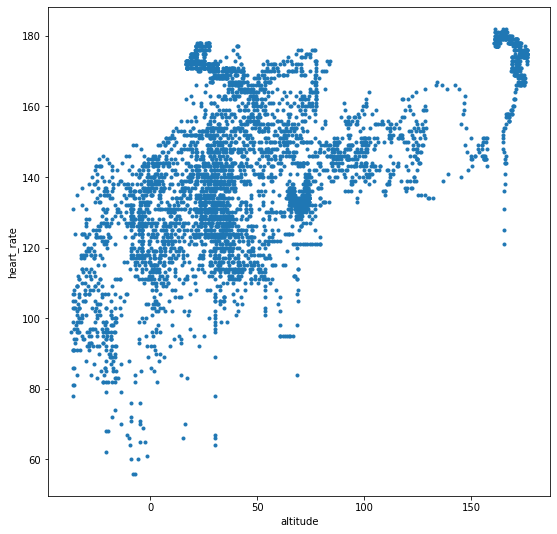

In [9]:
plt.figure(figsize=(9,9))
x = dataset["altitude"]
y = dataset["heart_rate"]
plt.xlabel("altitude")
plt.ylabel("heart_rate")
plt.scatter(x, y, marker='.')
plt.show()

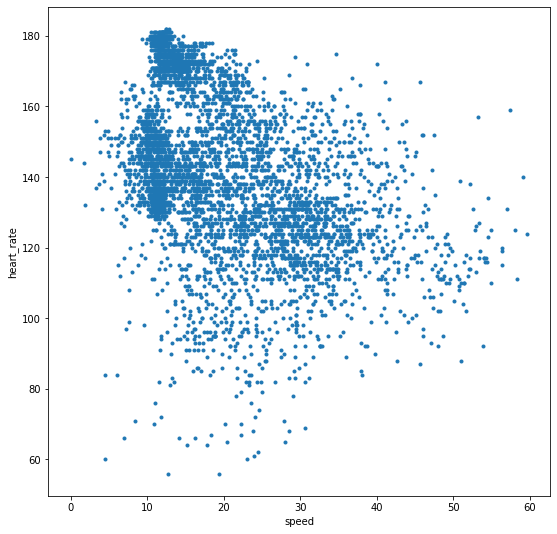

In [10]:
plt.figure(figsize=(9,9))
x = dataset["speed"]
y = dataset["heart_rate"]
plt.xlabel("speed")
plt.ylabel("heart_rate")
plt.scatter(x, y, marker='.')
plt.show()

In [11]:
#s
#Normalizing the data

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X = sc.fit_transform(X)

In [12]:
X

array([[-0.71080192, -0.16176374],
       [-0.71080192,  0.2074871 ],
       [-0.71080192,  0.58191263],
       ...,
       [-1.47195041, -0.91985531],
       [-1.47195041, -0.20685744],
       [-1.41044346, -1.35194163]])

**Splitting the data for training and testing¶**

In [13]:
from sklearn.model_selection import train_test_split

#s
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.1,random_state=9)

In [14]:
print(X[0])

[-0.71080192 -0.16176374]


In [15]:
print(len(y))

4989


In [16]:
print(len(X))

4989


In [17]:
print(X.shape)
print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)

(4989, 2)
(4490, 2)
(4490,)
(499, 2)
(499,)


In [18]:
y_test

2604    147
1368    174
1320    173
343     127
4802    110
       ... 
1682    175
431     119
392     131
577     130
1894    180
Name: heart_rate, Length: 499, dtype: int64

**Simulate local clients**

In [19]:
#shard creation...share the training set into 10 shards, one per client
#creating clients as data shards
def create_clients(X, y, num_clients=10, initial='clients'):
    ''' return: a dictionary with keys clients' names and value as 
                data shards - tuple of images and label lists.
        args: 
            X:  training data
            y: binarized labels for each training data
            num_client: number of fedrated members (clients)
            initials: the clients'name prefix, e.g, clients_1 
            
    '''

    #create a list of client names
    client_names = ['{}_{}'.format(initial, i+1) for i in range(num_clients)]

    #randomize the data
    data = list(zip(X, y))
    random.shuffle(data)

    #shard data and place at each client
    size = len(data)//num_clients
    shards = [data[i:i + size] for i in range(0, size*num_clients, size)]

    #number of clients must equal number of shards
    assert(len(shards) == len(client_names))

    return {client_names[i] : shards[i] for i in range(len(client_names))} 

In [20]:
#create clients
clients = create_clients(X_train, y_train, num_clients=3, initial='client')

**Processing and Batching client's and test data**

In [21]:
#process each of the client's data into tensorflow dataset and batch them. 
def batch_data(data_shard, bs=32):
    '''Takes in a clients data shard and create a tfds object of it
    args:
        shard: a data, label constituting a client's data shard
        bs:batch size
    return:
        tfds object'''
    #seperate shard into data and labels lists
    data, label = zip(*data_shard)
    dataset = tf.data.Dataset.from_tensor_slices((list(data), list(label)))
    return dataset.shuffle(len(label)).batch(bs)

In [22]:
#process and batch the training data for each client
clients_batched = dict()
for (client_name, data) in clients.items():
    clients_batched[client_name] = batch_data(data)
    print("aashma")

#process and batch the test data set  
test_batched = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(len(y_test))

aashma
aashma
aashma


In [65]:
test_batched

<BatchDataset element_spec=(TensorSpec(shape=(None, 2), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [23]:
print(clients_batched['client_1'])

<BatchDataset element_spec=(TensorSpec(shape=(None, 2), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


**Model architecture** 

**creating MLP model**

In [24]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

def lstm_model():
  model = Sequential()

  model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
  model.add(Dropout(0.2))

  model.add(LSTM(units = 50, return_sequences = True))
  model.add(Dropout(0.2))

  model.add(LSTM(units = 50, return_sequences = True))
  model.add(Dropout(0.2))

  model.add(LSTM(units = 50))
  model.add(Dropout(0.2))

  model.add(Dense(units = 1))

  return model

model = lstm_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 2, 50)             10400     
                                                                 
 dropout (Dropout)           (None, 2, 50)             0         
                                                                 
 lstm_1 (LSTM)               (None, 2, 50)             20200     
                                                                 
 dropout_1 (Dropout)         (None, 2, 50)             0         
                                                                 
 lstm_2 (LSTM)               (None, 2, 50)             20200     
                                                                 
 dropout_2 (Dropout)         (None, 2, 50)             0         
                                                                 
 lstm_3 (LSTM)               (None, 50)                2

In [25]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

**Global Training Parameters**

In [26]:
learning_rate = 0.01 
comms_round = 2 #no of global epochs(aggregation)

#s
loss='mean_squared_error' 
metrics = ['mae']
optimizer=keras.optimizers.Adam(learning_rate=learning_rate) #optimizer           

**Federated Averaging**

In [27]:
def weight_scalling_factor(clients_trn_data, client_name):
    client_names = list(clients_trn_data.keys())
    #get the bs
    bs = list(clients_trn_data[client_name])[0][0].shape[0]
    #first calculate the total training data points across clients
    global_count = sum([tf.data.experimental.cardinality(clients_trn_data[client_name]).numpy() for client_name in client_names])*bs
    # get the total number of data points held by a client
    local_count = tf.data.experimental.cardinality(clients_trn_data[client_name]).numpy()*bs
    return local_count/global_count #scaling factor

In [28]:
#this scales each of the local model's weights based on the value of their scaling factor
def scale_model_weights(weight, scalar):
    '''function for scaling a models weights'''
    weight_final = []
    steps = len(weight)
    for i in range(steps):
        weight_final.append(scalar * weight[i])
    return weight_final

In [29]:
#sums all clients scaled weights together
def sum_scaled_weights(scaled_weight_list):
    '''Return the sum of the listed scaled weights. The is equivalent to scaled avg of the weights'''
    avg_grad = list()
    #get the average grad accross all client gradients
    for grad_list_tuple in zip(*scaled_weight_list):
        layer_mean = tf.math.reduce_sum(grad_list_tuple, axis=0)
        avg_grad.append(layer_mean)
        
    return avg_grad

In [30]:
def test_model(X_test, Y_test, model, comm_round):
    cce = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
    #logits = model.predict(X_test, batch_size=100)
    print(Y_test.shape)
    logits = model.predict(X_test)
    print(logits.shape)
    logits = logits.Flatten()
    loss = cce(Y_test, logits)
    acc = accuracy_score(tf.argmax(logits, axis=1), tf.argmax(Y_test, axis=1))
    print('comm_round: {} | global_acc: {:.3%} | global_loss: {}'.format(comm_round, acc, loss))
    return logits, acc, loss

**Federated Model Training**

In [46]:
#s
#initialize global model

smlp_global = lstm_model()

global_model = model
global_r2_list = []
global_loss_list = []
global_precision_list = []

#s
history=[]

In [47]:
from sklearn.metrics import r2_score

In [69]:
#commence global training loop
for comm_round in range(comms_round):
    
    # get the global model's weights - will serve as the initial weights for all local models
    global_weights = global_model.get_weights()
    
    #initial list to collect local model weights after scalling
    scaled_local_weight_list = list()

    #randomize client data - using keys
    client_names= list(clients_batched.keys())
    print(client_names)
    random.shuffle(client_names)
    
    #loop through each client and create new local model
    for client in client_names:        
        
   #santee
        local_model = lstm_model()
        local_model.compile(optimizer = 'adam', loss = 'mean_squared_error' ,metrics= metrics)
        
        #set local model weight to the weight of the global model
        local_model.set_weights(global_weights)
        
        print(f"{len(clients_batched[client])}")

        #fit local model with client's data
        print('Communicating With: ', client)
        history.append(local_model.fit(clients_batched[client], epochs = 5, batch_size = 32,verbose=1))
      
        #scale the model weights and add to list
        scaling_factor = weight_scalling_factor(clients_batched, client)
        scaled_weights = scale_model_weights(local_model.get_weights(), scaling_factor)
        scaled_local_weight_list.append(scaled_weights)
        
        #clear session to free memory after each communication round
        K.clear_session()
 #endsantee

    #to get the average over all the local model, we simply take the sum of the scaled weights
    average_weights = sum_scaled_weights(scaled_local_weight_list)
    
    #update global model 
    global_model.set_weights(average_weights)


#saving the model
    model_json = global_model.to_json()
    with open("global_model.json", "w") as json_file:
      json_file.write(model_json)
    # serialize weights to HDF5
    print("Saved model to disk")
    global_model.save_weights("model.h5")

    #test global model and print out metrics after each communications round

    for(X_test, Y_test) in test_batched:

        preds = global_model.predict(X_test)
        preds = preds.flatten()
        global_r2 = r2_score(Y_test, preds)
        print('comm_round: {} | global_r2: {}'.format(comm_round, global_r2))

        global_r2_list.append(global_r2)
        y_pred = global_model.predict(X_test)

        print(f"Preds: {preds[:5]}")
        print(f"Y_test: {Y_test[:5]}")

['client_1', 'client_2', 'client_3']
47
Communicating With:  client_3
Epoch 1/5
47/47 [==============================] - 10s 11ms/step - loss: 658.0908 - mae: 20.4872
Epoch 2/5
47/47 [==============================] - 1s 11ms/step - loss: 645.4216 - mae: 20.3699
Epoch 3/5
47/47 [==============================] - 1s 11ms/step - loss: 636.9991 - mae: 20.3649
Epoch 4/5
47/47 [==============================] - 1s 11ms/step - loss: 637.4413 - mae: 20.4305
Epoch 5/5
47/47 [==============================] - 1s 11ms/step - loss: 629.4866 - mae: 20.0211
47
Communicating With:  client_2
Epoch 1/5
47/47 [==============================] - 7s 11ms/step - loss: 698.5052 - mae: 20.9339
Epoch 2/5
47/47 [==============================] - 1s 11ms/step - loss: 671.7274 - mae: 20.7261
Epoch 3/5
47/47 [==============================] - 1s 11ms/step - loss: 667.1790 - mae: 20.5994
Epoch 4/5
47/47 [==============================] - 1s 12ms/step - loss: 642.5334 - mae: 20.3355
Epoch 5/5
47/47 [===============

In [ ]:
globa

In [68]:
for(X_test, Y_test) in test_batched:
    print(X_test)
    break

tf.Tensor(
[[ 8.49936891e-01 -9.92300923e-01]
 [-6.18541501e-01 -6.60012126e-01]
 [-5.07060157e-01 -5.86827274e-01]
 [-6.49294975e-01 -1.88746034e-01]
 [-9.37608795e-01  3.26055214e+00]
 [-1.53395204e-01 -5.89414617e-01]
 [-6.87736818e-01 -1.10873137e+00]
 [-1.64878289e+00 -3.66533477e-01]
 [ 9.30664761e-01 -8.58128694e-01]
 [ 2.11467352e+00 -7.87900806e-01]
 [-1.39506672e+00  7.84895612e-02]
 [ 2.28381762e+00 -9.03592011e-01]
 [-8.10750714e-01  2.01640965e+00]
 [ 4.34764990e-01 -8.91024916e-01]
 [ 1.15362745e+00 -8.23014750e-01]
 [-3.26383496e-01  1.04726480e+00]
 [ 2.32610365e+00 -7.73115988e-01]
 [ 7.03857889e-01 -8.13034998e-01]
 [ 4.50141727e-01  1.79395948e-01]
 [ 2.73309250e-01 -9.01743909e-01]
 [ 3.65569673e-01 -9.41293299e-01]
 [-5.45502000e-01 -7.13976713e-01]
 [ 3.42504567e-01  1.77209053e+00]
 [-2.72564916e-01 -1.17039664e-01]
 [-1.39506672e+00 -4.03865144e-01]
 [ 2.12620607e+00 -8.45191978e-01]
 [ 8.88378734e-01 -9.15789487e-01]
 [-1.06446688e+00  9.11983707e-01]
 [-3.0331

In [55]:
X_test[:5]

<tf.Tensor: shape=(5, 2), dtype=float64, numpy=
array([[ 0.84993689, -0.99230092],
       [-0.6185415 , -0.66001213],
       [-0.50706016, -0.58682727],
       [-0.64929498, -0.18874603],
       [-0.9376088 ,  3.26055214]])>

In [56]:
preds[:5]

array([131.4113, 131.4113, 131.4113, 131.4113, 131.4113], dtype=float32)

In [61]:
preds = global_model.evaluate(X_test, Y_test)

16/16 [==============================] - 4s 8ms/step - loss: 629.2258


In [62]:
preds

629.2257690429688

In [58]:
global_model.predict(X_test[0:5])

array([[131.4113],
       [131.4113],
       [131.4113],
       [131.4113],
       [131.4113]], dtype=float32)

In [49]:
global_r2 = r2_score(Y_test, logits)

In [40]:
print(logits.flatten().shape)

(499,)


In [41]:
print(Y_test.shape)

(499,)


In [82]:
global_loss

0

In [ ]:
y_pred = global_model.predict(X_test)
# Model Precision: what percentage of positives are labeled as such?
print("Precision:",precision_score(tf.argmax(y_pred, axis=1), tf.argmax(y_test, axis=1), average='weighted'))
# print("MAP", average_precision_score(tf.argmax(y_pred, axis=1), tf.argmax(Y_test, axis=1), average='macro', pos_label=1, sample_weight=None))
global_prec= np.array(global_precision_list)
global_acc = np.array(global_acc_list)
print(global_prec)
print(global_acc)



Precision: 0.0
[0. 0.]
[0.00833275 0.00833275]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


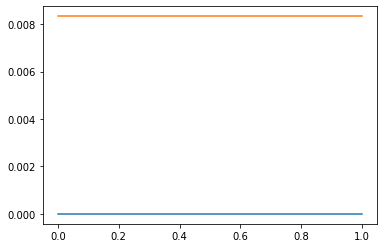

In [ ]:
plt.plot(global_prec)
plt.plot(global_acc)


**Saving and Loading Models**

In [ ]:
#s
global_model.save("/content/drive/MyDrive/global_model/")


INFO:tensorflow:Assets written to: /content/drive/MyDrive/global_model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/global_model/assets


In [ ]:
#s
import tensorflow as tf
global_model = tf.keras.models.load_model("/content/drive/MyDrive/global_model/")

In [ ]:
# # precision recall curve
# precision = dict()
# recall = dict()
# for i in range(6):
#     precision[i], recall[i], _ = precision_recall_curve(y_test[:, i], y_pred[:, i])
#     plt.plot(recall[i], precision[i], lw=2, label='class {}'.format(i))
#     print(recall[i])
# plt.xlabel("recall")
# plt.ylabel("precision")
# plt.legend(loc="best")
# plt.title("precision vs. recall curve")
# plt.show()

In [ ]:
attack1 = pd.read_csv('drive/My Drive/endomondo/user1.csv')
# attack1 = pd.read_csv("Attack1.csv")

print(model_features)
X1= dataset[model_features].values
y1= dataset[['heart_rate']].values

# X1 = attack1.iloc[:,:6].values
# y1 = attack1.iloc[:,6:7].values
#Normalizing the data
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X1 = sc.fit_transform(X1)
lb = LabelBinarizer()
y1 = lb.fit_transform(y1)
from sklearn.model_selection import train_test_split
X_train1,X_test1,y_train1,y_test1 = train_test_split(X1,y1,test_size=0.1,random_state=109)
y1_pred = global_model.predict(X_test1)



attack1 = pd.read_csv('drive/My Drive/endomondo/user2.csv')
# attack2 = pd.read_csv("Attack2.csv")

# X2 = attack1.iloc[:,:6].values
# y2 = attack1.iloc[:,6:7].values
X2= dataset[model_features].values
y2= dataset[['heart_rate']].values
#Normalizing the data
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X2 = sc.fit_transform(X2)
lb = LabelBinarizer()
y2 = lb.fit_transform(y2)
from sklearn.model_selection import train_test_split
X_train2,X_test2,y_train2,y_test2 = train_test_split(X2,y2,test_size=0.1,random_state=109)
y2_pred = global_model.predict(X_test2)


# attack4 = pd.read_csv("Attack4.csv")
attack1 = pd.read_csv('drive/My Drive/endomondo/user3.csv')

# X4 = attack1.iloc[:,:6].values
# y4 = attack1.iloc[:,6:7].values
X4= dataset[model_features].values
y4= dataset[['heart_rate']].values
#Normalizing the data
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X4 = sc.fit_transform(X4)
lb = LabelBinarizer()
y4 = lb.fit_transform(y4)
from sklearn.model_selection import train_test_split
X_train4,X_test4,y_train4,y_test4 = train_test_split(X4,y4,test_size=0.1,random_state=109)
y4_pred = global_model.predict(X_test4)





# attack8 = pd.read_csv("Attack8.csv")
# X8 = attack1.iloc[:,:6].values
# y8 = attack1.iloc[:,6:7].values
# #Normalizing the data
# from sklearn.preprocessing import StandardScaler
# sc = StandardScaler()
# X8 = sc.fit_transform(X8)
# lb = LabelBinarizer()
# y8 = lb.fit_transform(y8)
# from sklearn.model_selection import train_test_split
# X_train8,X_test8,y_train8,y_test8 = train_test_split(X8,y8,test_size=0.1,random_state=109)
# y8_pred = global_model.predict(X_test8)



# attack16 = pd.read_csv("Attack16.csv")
# X16 = attack1.iloc[:,:6].values
# y16 = attack1.iloc[:,6:7].values
# #Normalizing the data
# from sklearn.preprocessing import StandardScaler
# sc = StandardScaler()
# X16 = sc.fit_transform(X16)
# lb = LabelBinarizer()
# y16 = lb.fit_transform(y16)
# from sklearn.model_selection import train_test_split
# X_train16,X_test16,y_train16,y_test16 = train_test_split(X16,y16,test_size=0.1,random_state=109)
# y16_pred = global_model.predict(X_test16)


print("Precision for Attack 1:",precision_score(tf.argmax(y1_pred, axis=1), tf.argmax(y_test1, axis=1), average='weighted'))
print("Precision for Attack 2:",precision_score(tf.argmax(y2_pred, axis=1), tf.argmax(y_test2, axis=1), average='weighted'))
print("Precision for Attack 4:",precision_score(tf.argmax(y4_pred, axis=1), tf.argmax(y_test4, axis=1), average='weighted'))
# print("Precision for Attack 8:",precision_score(tf.argmax(y8_pred, axis=1), tf.argmax(y_test8, axis=1), average='weighted'))
# print("Precision for Attack 16:",precision_score(tf.argmax(y16_pred, axis=1), tf.argmax(y_test16, axis=1), average='weighted'))

# print("MAP", average_precision_score(tf.argmax(y_pred, axis=1), tf.argmax(Y_test, axis=1), average='macro', pos_label=1, sample_weight=None))
global_prec= np.array(global_precision_list)
print(f"Precision for each round: {global_prec}")

['altitude', 'heart_rate', 'speed']
Precision for Attack 1: 0.0
Precision for Attack 2: 0.0
Precision for Attack 4: 0.0
Precision for each round: [0. 0.]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
